### Libraries

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kmodes.kmodes import KModes
from sklearn import metrics

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from yellowbrick.model_selection import FeatureImportances

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [4]:
df=pd.read_csv('/Users/apple/Desktop/googleplaystore.csv')

In [5]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [6]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

### Data Cleaning & Transformation

In [7]:
df.drop(['App','Last Updated'], axis=1, inplace=True)

In [8]:
# Dropping a category of value 1.9
df.drop(df.loc[df['Category']=='1.9'].index, axis=0, inplace=True)

In [9]:
# Dropping rows with rating value = nan
df.drop(df.loc[df.Rating.isna()].index, axis=0, inplace=True)

In [10]:
# Converting data type to float
df.Rating=df.Rating.astype(float)

In [11]:
# Converting data type to Integer
df.Reviews=df.Reviews.astype(int)

In [12]:
df.Size.dtype

dtype('O')

In [13]:
# Dropping rows where Size is defined as ' Varies with Device'
df.drop(df.loc[df.Size=='Varies with device'].index, axis=0, inplace=True)

In [14]:
# Converting Size column to Float 
df.Size=df.Size.apply(lambda x: round(float(x.strip('M')),2) if 'M' in x else round(float(x.strip('k'))/1000),2)

In [15]:
df.Installs.value_counts()

1,000,000+        1302
100,000+          1037
10,000+            969
10,000,000+        825
1,000+             690
5,000,000+         535
500,000+           491
50,000+            437
5,000+             420
100+               303
100,000,000+       201
500+               197
50,000,000+        147
10+                 67
50+                 56
500,000,000+        30
1,000,000,000+      10
5+                   9
1+                   3
Name: Installs, dtype: int64

In [16]:
# Converting Installs Columns to Integer
df.Installs=df.Installs.apply(lambda x: int(x.strip('+').replace(',','')))

In [17]:
# Ordinal Binning of Total # of Installs:
# 1-10,000 (1), 10,000 - 100,000 (2), 100,000 - 1,000,000 (3), 1,000,000 - 10,000,000 (4), 10,000,000 - 1,000,000,000 (5)
df.Installs=df.Installs.apply(lambda x: 0 if (1<=x<10000) else 1 if (10000<=x<100000) 
                              else 2 if (100000<=x<1000000) else 3 if (1000000<=x<10000000) else 4)

In [18]:
df.Type.unique()

array(['Free', 'Paid'], dtype=object)

In [19]:
# Converting Type to numerical
dct={'Free':0, 'Paid':1}
df.Type=df.Type.map(dct)

In [20]:
# Converting Price to float type
df.Price=df.Price.str.strip('$').astype(float)

In [21]:
dum_lst=[]
dum_lst.append('Content Rating')

In [22]:
# Listing categories in Genres in alphabetical order to see repetition and aggregate them in one 
sorted(df.Genres.value_counts().to_dict().keys())

['Action',
 'Action;Action & Adventure',
 'Adventure',
 'Adventure;Action & Adventure',
 'Adventure;Brain Games',
 'Adventure;Education',
 'Arcade',
 'Arcade;Action & Adventure',
 'Arcade;Pretend Play',
 'Art & Design',
 'Art & Design;Creativity',
 'Art & Design;Pretend Play',
 'Auto & Vehicles',
 'Beauty',
 'Board',
 'Board;Action & Adventure',
 'Board;Brain Games',
 'Board;Pretend Play',
 'Books & Reference',
 'Books & Reference;Education',
 'Business',
 'Card',
 'Card;Action & Adventure',
 'Card;Brain Games',
 'Casino',
 'Casual',
 'Casual;Action & Adventure',
 'Casual;Brain Games',
 'Casual;Creativity',
 'Casual;Education',
 'Casual;Music & Video',
 'Casual;Pretend Play',
 'Comics',
 'Comics;Creativity',
 'Communication',
 'Dating',
 'Education',
 'Education;Action & Adventure',
 'Education;Brain Games',
 'Education;Creativity',
 'Education;Education',
 'Education;Music & Video',
 'Education;Pretend Play',
 'Educational',
 'Educational;Action & Adventure',
 'Educational;Brain Games

In [23]:
# Re-adjusting categories in Genres
df.Genres=df.Genres.apply(lambda x: 'Action' if 'Action' in x else 'Adventure' if 'Adventure' in x else 'Arcade' if 'Arcade' in x
                else 'Art & Design' if 'Art & Design' in x else 'Board' if 'Board' in x else 'Books & Reference' if 'Books & Reference' in x
                else 'Card' if 'Card' in x else 'Casual' if 'Casual' in x else 'Comics' if 'Comics' in x
                else 'Education' if 'Education' in x else 'Education' if 'Educational' in x 
                else 'Entertainment' if 'Entertainment' in x else 'Health & Fitness' if 'Health & Fitness' in x
                else 'Lifestyle' if 'Lifestyle' in x else 'Music' if 'Music' in x else 'Parenting' if 'Parenting' in x
                else 'Puzzle' if 'Puzzle' in x else 'Racing' if 'Racing' in x else 'Role Playing' if 'Role Playing' in x
                else 'Simulation' if 'Simulation' in x else 'Sports' if 'Sports' in x else 'Strategy' if 'Strategy' in x
                else 'Travel & Local' if 'Travel & Local' in x else 'Video Players & Editors' if 'Video Players & Editors' in x
                else x)

In [24]:
df.Genres.value_counts()

Tools                      634
Education                  592
Entertainment              474
Action                     438
Medical                    324
Lifestyle                  280
Personalization            280
Finance                    266
Sports                     261
Business                   246
Photography                236
Productivity               235
Health & Fitness           223
Casual                     215
Communication              211
Arcade                     187
Simulation                 185
Shopping                   179
Social                     177
Dating                     173
News & Magazines           169
Travel & Local             159
Books & Reference          146
Puzzle                     128
Video Players & Editors    117
Role Playing               109
Strategy                    97
Maps & Navigation           95
Food & Drink                84
Racing                      84
Adventure                   71
Auto & Vehicles             63
Librarie

In [25]:
# Dropping all columns with Android version = Varies with Device and nan
df.drop(df.loc[df['Android Ver']=='Varies with device'].index, axis=0, inplace=True)

In [26]:
df.drop(df.loc[(df['Android Ver']=='nan')].index, axis=0, inplace=True)

In [27]:
# Keeping the numerical part of Android Ver 
df['Android Ver']=df['Android Ver'].apply(str).apply(lambda x: x.split(' ')[0])

In [28]:
# Choosing first 3 values
df['Android Ver']=df['Android Ver'].apply(str).apply(lambda x: x[:3])

In [29]:
# Converting to numerical values
df['Android Ver']=df['Android Ver'].astype(float)

In [30]:
df['Android Ver'].value_counts()

4.0    2305
4.1    1931
4.4     812
2.3     801
5.0     493
4.2     318
3.0     211
2.2     206
4.3     195
2.1     113
1.6      87
6.0      45
7.0      40
2.0      34
3.2      31
5.1      17
1.5      15
3.1       8
8.0       5
7.1       2
1.0       2
Name: Android Ver, dtype: int64

In [31]:
labels=[1,2,3,4,5,6,7,8]
cutoffs=(1,2,3,4,5,6,7,8,9)
df['Android_Ver_bin']=pd.cut(df['Android Ver'], cutoffs, right=False, labels=labels)
df.drop('Android Ver', axis=1, inplace=True)

In [32]:
df.drop(df.loc[(df['Android_Ver_bin'].isna())].index, axis=0, inplace=True)

In [33]:
df['Android_Ver_bin']=df['Android_Ver_bin'].astype(int)

In [34]:
# Choosing the first 3 digits of the version number
df['Current Ver']=df['Current Ver'].apply(str).apply(lambda x: x[:3])

In [35]:
# Dropping any row that contained an alphabatical value or any value with signs
df.drop(df.loc[df['Current Ver'].str.contains('[a-zA-Z]') | df['Current Ver'].str.contains('_') | df['Current Ver'].str.contains('[|]')].index, axis=0, inplace=True)

In [36]:
df['Current Ver']=df['Current Ver'].apply(lambda x: x.replace(',','.').replace(';','.'))

In [37]:
df['Current Ver']=df['Current Ver'].astype(float)

In [38]:
df['Current Ver']=df['Current Ver'].apply(lambda x: int(x))

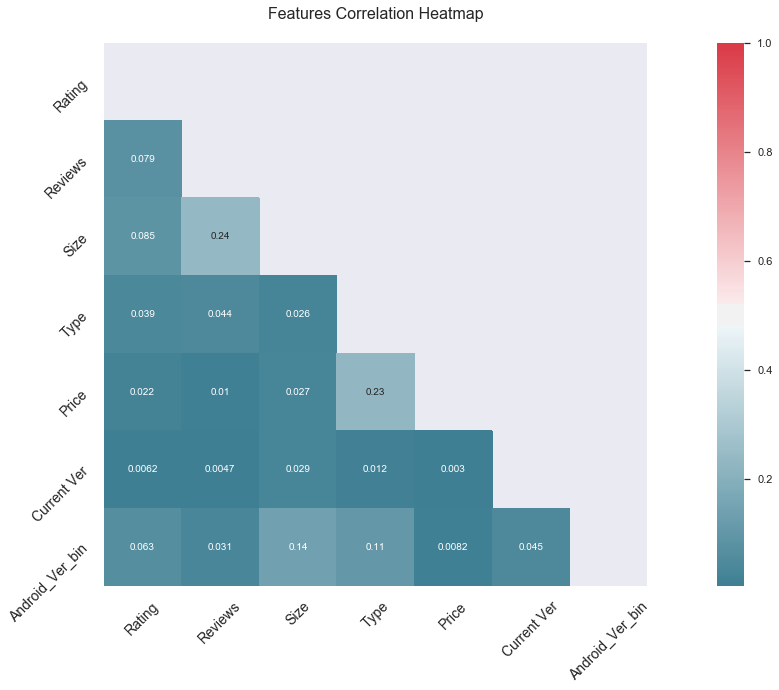

In [39]:
# Correlation Heatmap
plt.figure(figsize=(25,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(abs(df.drop('Installs',axis=1).corr()))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(abs(df.drop('Installs',axis=1).corr()), annot=True, mask=mask, cmap=cmap, square=True)
plt.title('Features Correlation Heatmap\n', fontsize=16)
plt.xticks(fontsize= 14, rotation=45)
plt.yticks(fontsize= 14, rotation=45);

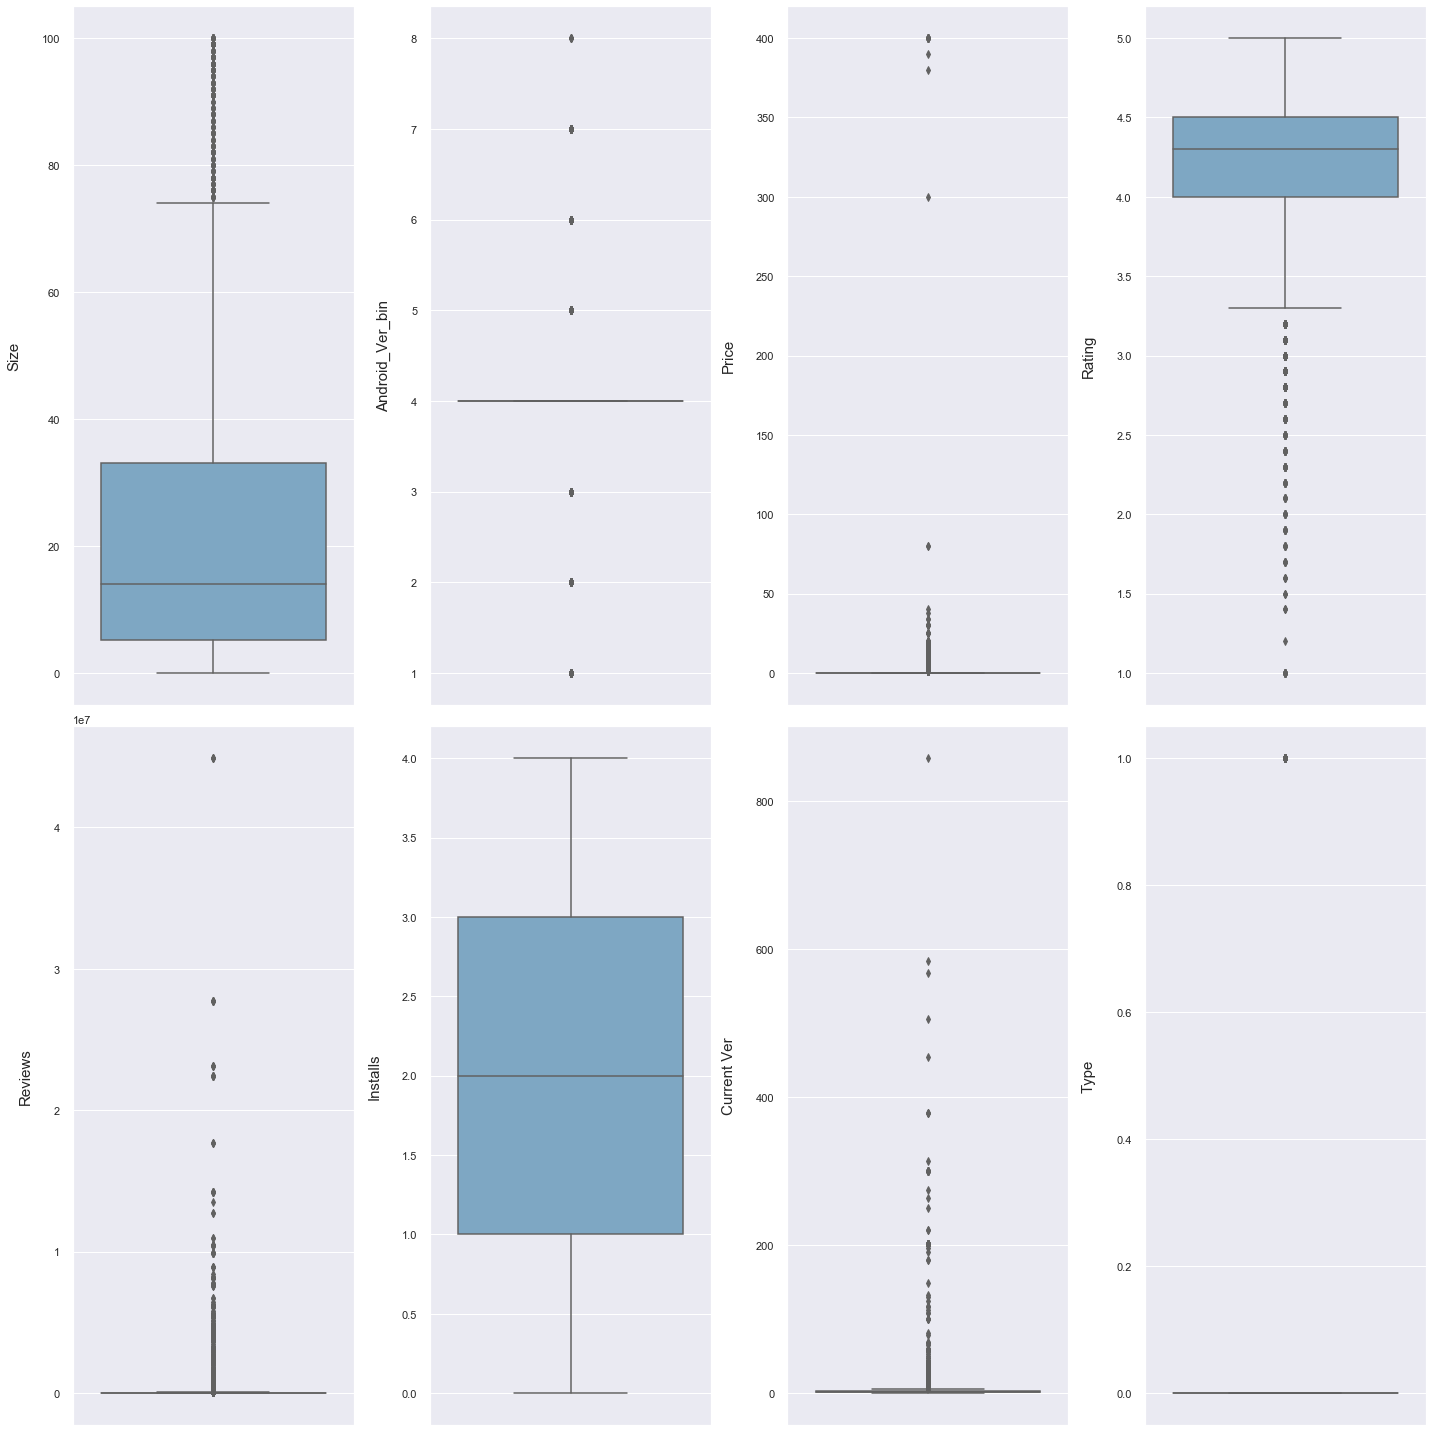

In [41]:
# Box-Plot to identify outliers in Features
num_features=list(set(df._get_numeric_data().columns))

fig, axes=plt.subplots(2,4,figsize=(20,20))
for idx,feature in enumerate(num_features):
    ax=axes[idx//4,idx%4]
    sns.boxplot(y=df[feature], ax=ax, palette='PuBu')
    ax.set_xlabel('', size=10)
    ax.set_ylabel(f'{feature}\n', size=15)
fig.tight_layout();

In [42]:
# 1st method - IQR Method (Not Adopted)
stats=df.describe()
stats=stats.T
stats['IQR']=stats['75%']-stats['25%']

outliers = pd.DataFrame(columns=df.columns)

for col in stats.index:
    iqr=stats.IQR[col]
    cutoff=iqr*1.6
    lower=stats.at[col,'25%']-cutoff
    upper=stats.at[col,'75%']+cutoff
    results=df[(df[col]<lower)|(df[col]>upper)].copy()
    results['Outlier']=col
    outliers=outliers.append(results)
    
outliers

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android_Ver_bin,Outlier
209,BUSINESS,3.1,4034,0.0,2,0,0.00,Everyone,Business,3,2,Rating
477,DATING,2.6,57,6.2,0,1,6.99,Everyone,Dating,1,4,Rating
492,DATING,3.1,31320,53.0,3,0,0.00,Mature 17+,Dating,6,4,Rating
514,DATING,3.0,1146,1.4,2,0,0.00,Mature 17+,Dating,2,4,Rating
518,DATING,1.9,953,19.0,2,0,0.00,Mature 17+,Dating,6,5,Rating
...,...,...,...,...,...,...,...,...,...,...,...,...
10814,FAMILY,4.0,785,31.0,1,0,0.00,Teen,Entertainment,1,3,Android_Ver_bin
10817,TOOLS,4.0,885,8.0,2,0,0.00,Everyone,Tools,1,5,Android_Ver_bin
10830,NEWS_AND_MAGAZINES,3.8,881,2.3,2,0,0.00,Everyone,News & Magazines,1,1,Android_Ver_bin
10832,WEATHER,3.8,1195,1.0,2,0,0.00,Everyone,Weather,6,2,Android_Ver_bin


In [43]:
# 2nd Method (1) - 95th Quantile
lst=['Current Ver', 'Reviews', 'Size', 'Price']

for i in lst:
    df=df.drop(df.loc[df[i] > df[i].quantile(q=0.95)].index)

df.shape

(6236, 11)

In [44]:
# 2nd Method (2) - 5th Quantile
lst=['Rating']

for i in lst:
    df=df.drop(df.loc[df[i] < df[i].quantile(q=0.05)].index)

df.shape

(5925, 11)

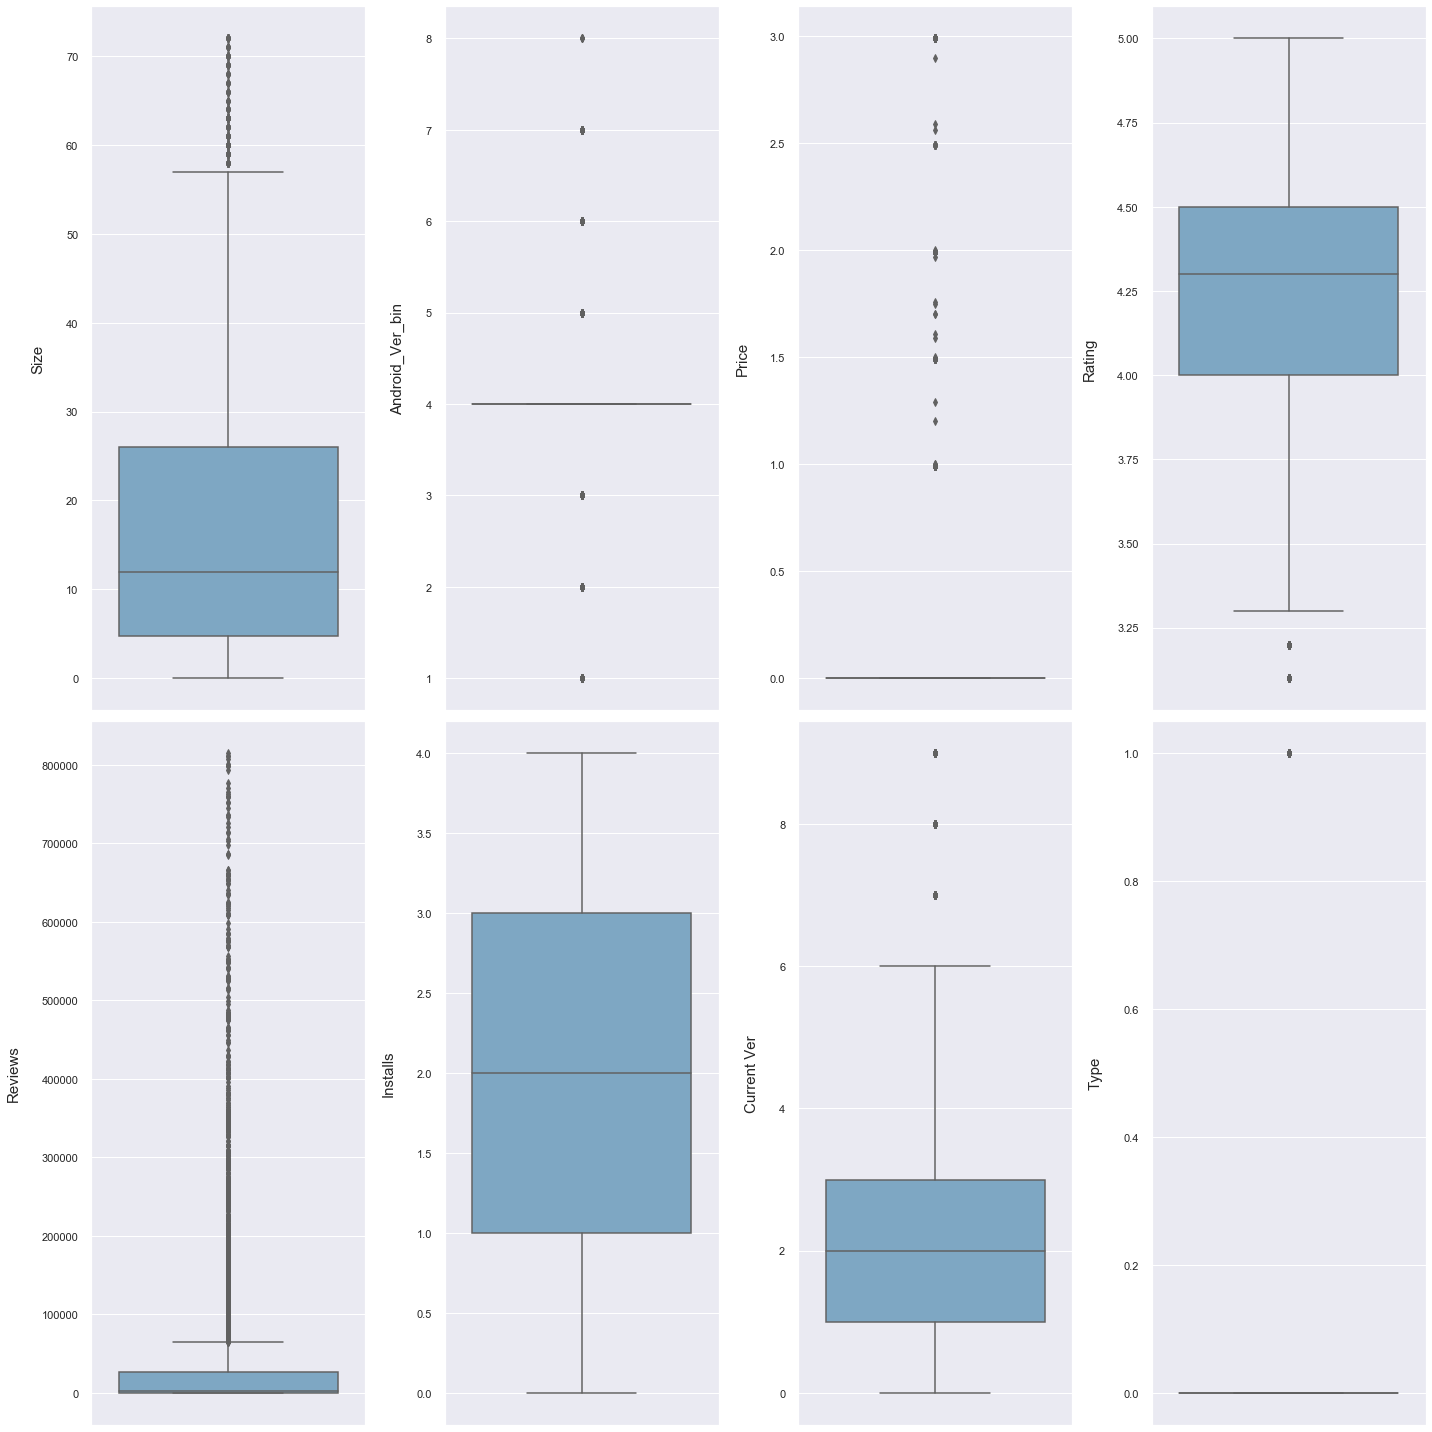

In [46]:
# Box-Plot to check distribution after removing top and lowest 5% of certain features
num_features=list(set(df._get_numeric_data().columns))

fig, axes=plt.subplots(2,4,figsize=(20,20))
for idx,feature in enumerate(num_features):
    ax=axes[idx//4,idx%4]
    sns.boxplot(y=df[feature], ax=ax, palette='PuBu')
    ax.set_xlabel('', size=10)
    ax.set_ylabel(f'{feature}\n', size=15)
fig.tight_layout();

In [47]:
df=df.reset_index(drop=True)

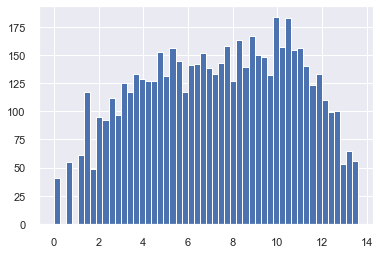

In [48]:
# Feature Scaling - Log
df.Reviews=round(df.Reviews.apply(np.log),2)
df.Reviews.hist(bins=50)

In [49]:
df.rename(columns={'Content Rating':'Content_Rating', 'Current Ver':'Current_Ver'}, inplace=True)

In [50]:
dum_lst=['Category', 'Content_Rating', 'Current_Ver', 'Android_Ver_bin', 'Genres']

In [51]:
df.Installs.value_counts(normalize=True)*100

3    25.721519
0    22.413502
2    21.535865
1    19.527426
4    10.801688
Name: Installs, dtype: float64

In [52]:
df

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Current_Ver,Android_Ver_bin
0,ART_AND_DESIGN,4.1,5.07,19.0,1,0,0.0,Everyone,Art & Design,1,4
1,ART_AND_DESIGN,3.9,6.87,14.0,2,0,0.0,Everyone,Art & Design,2,4
2,ART_AND_DESIGN,4.7,11.38,8.7,3,0,0.0,Everyone,Art & Design,1,4
3,ART_AND_DESIGN,4.3,6.87,2.8,2,0,0.0,Everyone,Art & Design,1,4
4,ART_AND_DESIGN,4.4,5.12,5.6,1,0,0.0,Everyone,Art & Design,1,2
...,...,...,...,...,...,...,...,...,...,...,...
5920,WEATHER,3.8,7.09,1.0,2,0,0.0,Everyone,Weather,6,2
5921,BOOKS_AND_REFERENCE,4.8,3.78,1.0,0,0,0.0,Everyone,Books & Reference,0,2
5922,FAMILY,4.0,1.95,2.6,0,0,0.0,Everyone,Education,1,4
5923,FAMILY,4.5,3.64,53.0,0,0,0.0,Everyone,Education,1,4


### Feature Engineering

In [53]:
df_1=pd.get_dummies(data=df, columns=dum_lst)

In [54]:
df_1

,Rating,Reviews,Size,Installs,Type,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Simulation,Genres_Social,Genres_Sports,Genres_Strategy,Genres_Tools,Genres_Travel & Local,Genres_Trivia,Genres_Video Players & Editors,Genres_Weather,Genres_Word
0,4.1,5.07,19.0,1,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,6.87,14.0,2,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,11.38,8.7,3,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.3,6.87,2.8,2,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.4,5.12,5.6,1,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,3.8,7.09,1.0,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5921,4.8,3.78,1.0,0,0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5922,4.0,1.95,2.6,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5923,4.5,3.64,53.0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X1=df_1.drop('Installs', axis=1)
y1=df_1['Installs']

In [56]:
# F-Classification - w/o standardizing the dummy columns
selection=SelectKBest(f_classif, k=5)
selection.fit(X1,y1)
cols = selection.get_support(indices=True)
X_1_1 = X1.iloc[:,cols]
X_1_1

,Rating,Reviews,Size,Type,Current_Ver_1
0,4.1,5.07,19.0,0,1
1,3.9,6.87,14.0,0,0
2,4.7,11.38,8.7,0,1
3,4.3,6.87,2.8,0,1
4,4.4,5.12,5.6,0,1
...,...,...,...,...,...
5920,3.8,7.09,1.0,0,0
5921,4.8,3.78,1.0,0,0
5922,4.0,1.95,2.6,0,1
5923,4.5,3.64,53.0,0,1


In [57]:
# Identify columns choosen 
mask = selection.get_support()
feat_name=X1.columns.to_list()
new_features = [] 

for bool, feature in zip(mask, feat_name):
    if bool:
        new_features.append(feature)

#### Clustering -  K-Means, Agglomerrative

In [58]:
df.columns

Index(['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content_Rating', 'Genres', 'Current_Ver', 'Android_Ver_bin'],
      dtype='object')

In [59]:
new_features

['Rating', 'Reviews', 'Size', 'Type', 'Current_Ver_1']

In [60]:
X_clust=X1.drop(columns=new_features)

In [61]:
pca=PCA(0.85)
x=pd.DataFrame(pca.fit_transform(X_clust))
x

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-0.356382,-0.219870,-0.058905,0.024627,-0.125676,-0.158605,-0.119286,-0.076044,0.022200,0.054716,...,-0.027754,-0.042499,0.113405,-0.019913,0.002802,-0.093371,0.057935,-0.055344,0.024131,-0.047895
1,-0.364778,-0.306456,-0.081896,0.001805,0.814613,-0.077739,-0.033203,0.094863,0.044493,0.043840,...,0.022934,0.029761,0.076064,-0.010640,0.031214,-0.017489,0.041564,-0.064063,0.015679,-0.022809
2,-0.356382,-0.219870,-0.058905,0.024627,-0.125676,-0.158605,-0.119286,-0.076044,0.022200,0.054716,...,-0.027754,-0.042499,0.113405,-0.019913,0.002802,-0.093371,0.057935,-0.055344,0.024131,-0.047895
3,-0.356382,-0.219870,-0.058905,0.024627,-0.125676,-0.158605,-0.119286,-0.076044,0.022200,0.054716,...,-0.027754,-0.042499,0.113405,-0.019913,0.002802,-0.093371,0.057935,-0.055344,0.024131,-0.047895
4,0.960401,-0.194573,-0.225397,-0.279895,-0.141250,-0.245460,-0.108679,-0.046265,0.293224,0.148856,...,-0.033633,0.044668,0.079203,-0.039568,0.005472,-0.116276,0.080193,-0.048963,0.035078,-0.048212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,0.960427,-0.203628,-0.240041,-0.278298,-0.188136,-0.244871,-0.086009,-0.105481,0.280882,0.116961,...,-0.008524,-0.051839,0.099884,0.044497,-0.084997,-0.434565,0.315093,-0.061883,0.168468,0.084425
5921,0.979211,-0.204659,-0.253472,-0.291509,-0.155446,-0.276180,-0.111009,-0.045238,0.332531,0.186853,...,-0.016550,-0.043505,0.913556,-0.329569,-0.623882,0.391041,0.319659,0.403077,-0.339652,0.064114
5922,-0.304352,0.089612,0.946290,-0.495622,-0.132157,0.082671,-0.223309,-0.067114,0.066739,-0.179906,...,-0.055142,-0.025677,-0.034154,-0.071905,-0.057663,-0.097217,0.025086,0.042255,0.002326,0.012873
5923,-0.304352,0.089612,0.946290,-0.495622,-0.132157,0.082671,-0.223309,-0.067114,0.066739,-0.179906,...,-0.055142,-0.025677,-0.034154,-0.071905,-0.057663,-0.097217,0.025086,0.042255,0.002326,0.012873


In [62]:
(pca.explained_variance_ratio_)

array([0.09181253, 0.07627059, 0.06700561, 0.06053278, 0.04794416,
       0.04441158, 0.03227042, 0.02958746, 0.02654891, 0.02490564,
       0.02294822, 0.02228397, 0.02187471, 0.02117678, 0.02023709,
       0.01962272, 0.01908607, 0.01831846, 0.01816857, 0.01717089,
       0.01652989, 0.01631072, 0.01522675, 0.01427615, 0.01387076,
       0.01366398, 0.01272313, 0.01217329, 0.01204213, 0.01148634,
       0.00984438])

In [63]:
single=AgglomerativeClustering(n_clusters=3, linkage='single')
kmeans = KMeans(3)

In [64]:
single.fit(x)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
y_s=single.labels_.astype(np.int)
y_km=kmeans.predict(x)

In [66]:
print('Model 1. Silhouette is',silhouette_score(x,y_s))
print('Model 2. Silhouette is',silhouette_score(x,y_km))

print('Model 1. Davies-Bouldin is',davies_bouldin_score(x,y_s))
print('Model 2. Davies-Bouldin is',davies_bouldin_score(x,y_km))

Model 1. Silhouette is 0.3786198483762523
Model 2. Silhouette is 0.1467122057983074
Model 1. Davies-Bouldin is 0.4705098913910528
Model 2. Davies-Bouldin is 2.464805393795125


In [67]:
(pd.DataFrame(y_km))[0].value_counts()

1    3426
2    1420
0    1079
Name: 0, dtype: int64

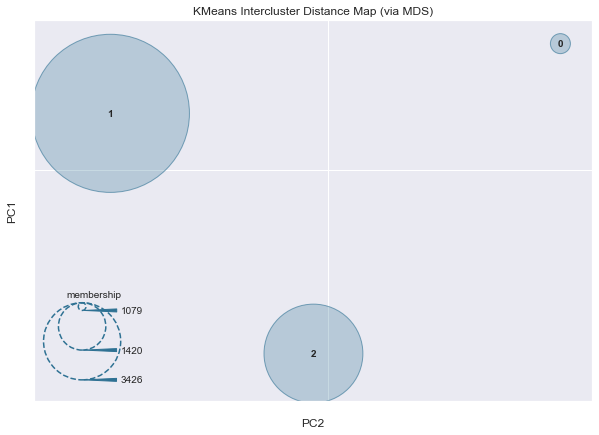

In [74]:
from yellowbrick.cluster import InterclusterDistance
plt.figure(figsize=(10,7))
viz=InterclusterDistance(kmeans)
viz.fit(x)
viz.show();

In [75]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show();

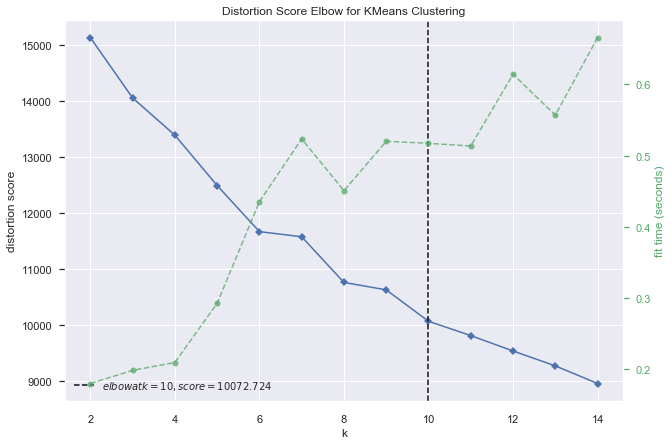

In [77]:
from yellowbrick.cluster import KElbowVisualizer
plt.figure(figsize=(10,7))
visualizer = KElbowVisualizer(kmeans, k=(2,15))
visualizer.fit(x) 
visualizer.show();

#### Clustering - K-Modes

In [78]:
kmodes = KModes(n_clusters=3, init='Huang')
kmodes.fit(X_clust)

KModes(cat_dissim=<function matching_dissim at 0x1a21c85dd0>, init='Huang',
       max_iter=100, n_clusters=3, n_init=1, n_jobs=1, random_state=None,
       verbose=0)

In [79]:
ykmodes=kmodes.predict(X_clust)

In [80]:
(pd.DataFrame(ykmodes))[0].value_counts()

0    3769
1    1252
2     904
Name: 0, dtype: int64

In [81]:
print('Model 1. Silhouette is',silhouette_score(x,ykmodes))
print('Model 1. Davies-Bouldin is',davies_bouldin_score(x,ykmodes))

Model 1. Silhouette is 0.10083799467676581
Model 1. Davies-Bouldin is 2.821418924177598


In [82]:
ykmodes

array([0, 2, 0, ..., 1, 1, 1], dtype=uint16)

In [83]:
X_1_1['Cluster']=y_km

In [84]:
X_1_1

,Rating,Reviews,Size,Type,Current_Ver_1,Cluster
0,4.1,5.07,19.0,0,1,1
1,3.9,6.87,14.0,0,0,1
2,4.7,11.38,8.7,0,1,1
3,4.3,6.87,2.8,0,1,1
4,4.4,5.12,5.6,0,1,2
...,...,...,...,...,...,...
5920,3.8,7.09,1.0,0,0,2
5921,4.8,3.78,1.0,0,0,2
5922,4.0,1.95,2.6,0,1,1
5923,4.5,3.64,53.0,0,1,1


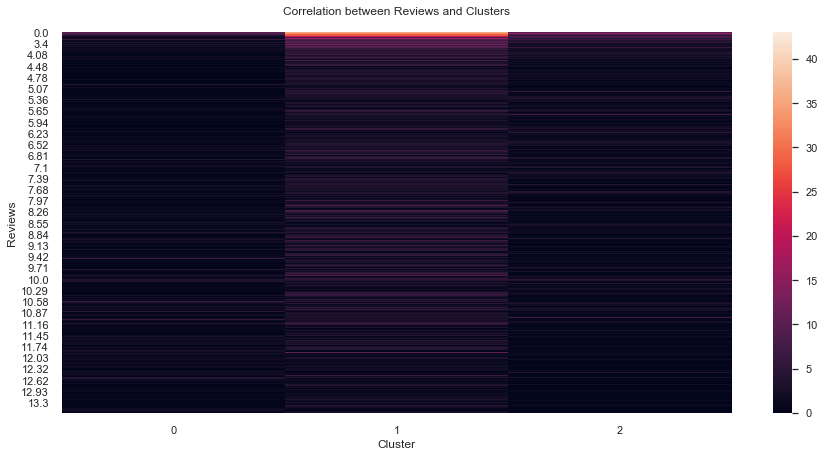

In [129]:
plt.figure(figsize=(15,7))
sns.heatmap(pd.crosstab(X_1_1.Reviews, X_1_1.Cluster))
plt.title('Correlation between Reviews and Clusters\n');

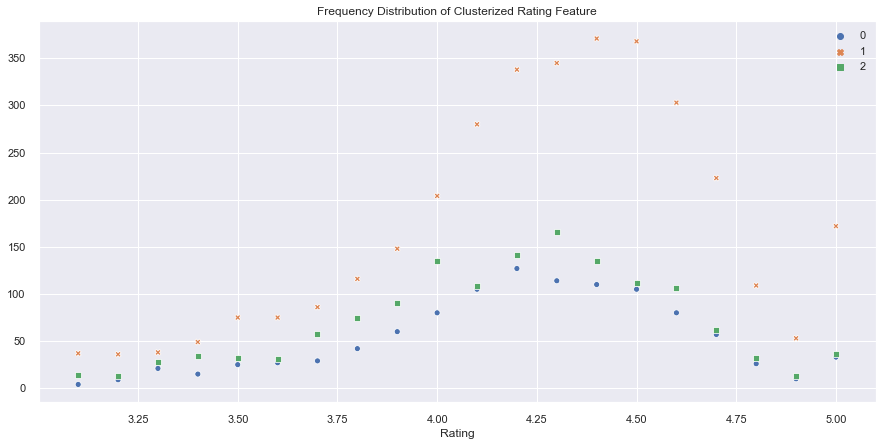

In [102]:
# Crosstab between Rating and Cluster
#pd.crosstab(X_1_1.Rating, X_1_1.Cluster, normalize='columns').round(2)
plt.figure(figsize=(15,7))
pd.options.display.max_rows = 155

rating_clust=pd.crosstab(X_1_1.Rating, X_1_1.Cluster)
sns.scatterplot(data=rating_clust)
plt.title('Frequency Distribution of Clusterized Rating Feature');

In [88]:
X_1_1.groupby('Cluster')['Rating'].agg('mean')

Cluster
0    4.219092
1    4.270549
2    4.173592
Name: Rating, dtype: float64

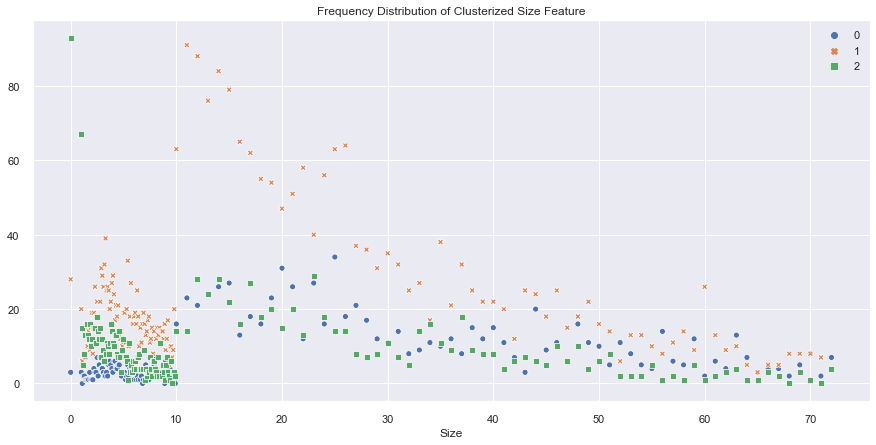

In [103]:
plt.figure(figsize=(15,7))

size_clust=pd.crosstab(X_1_1.Size, X_1_1.Cluster)
sns.scatterplot(data=size_clust)
plt.title('Frequency Distribution of Clusterized Size Feature');

In [90]:
X_1_1.groupby('Cluster')['Size'].agg('mean')

Cluster
0    25.167377
1    17.862697
2    13.847324
Name: Size, dtype: float64

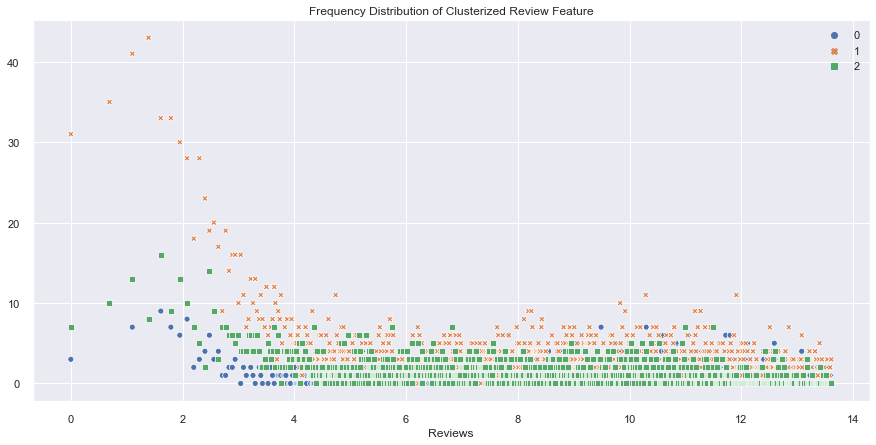

In [104]:
plt.figure(figsize=(15,7))

reviews_clust=pd.crosstab(X_1_1.Reviews, X_1_1.Cluster)
sns.scatterplot(data=reviews_clust)
plt.title('Frequency Distribution of Clusterized Review Feature');

In [92]:
X_1_1.groupby('Cluster')['Type'].agg('sum')

Cluster
0     26
1    126
2    129
Name: Type, dtype: int64

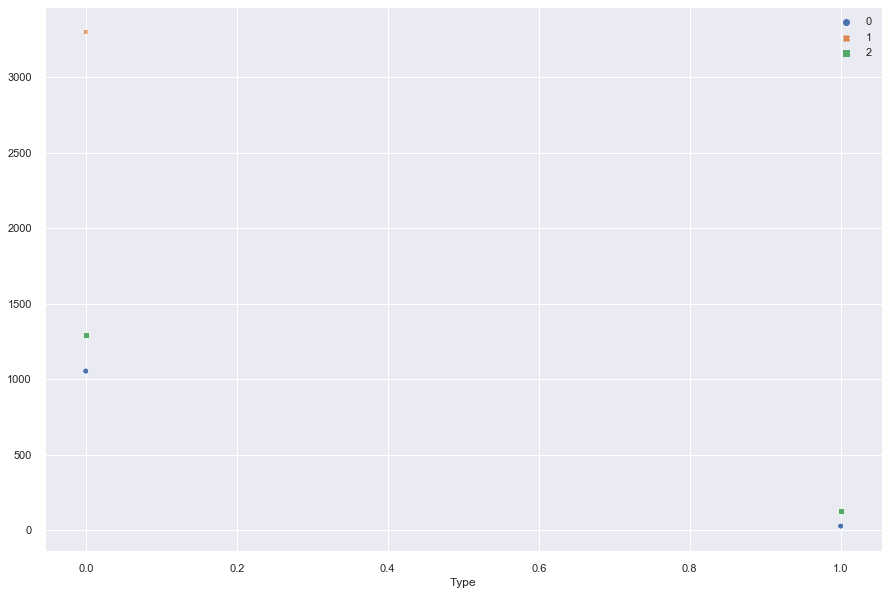

In [95]:
plt.figure(figsize=(15,10))

type_clust=pd.crosstab(X_1_1.Type, X_1_1.Cluster)
sns.scatterplot(data=type_clust);

In [96]:
pd.crosstab(X_1_1.Type, X_1_1.Cluster).round(2)

Cluster,0,1,2
Type,,,
0,1053,3300,1291
1,26,126,129


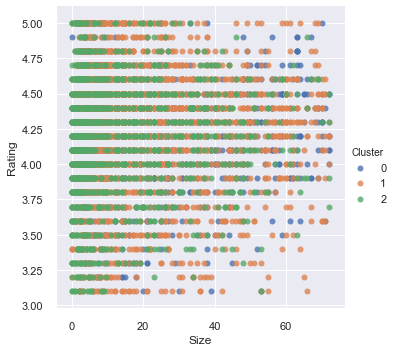

In [98]:
sns.lmplot(data=X_1_1, y='Rating',x='Size', hue='Cluster', fit_reg=False);

### Modeling 
#### Multi-Variate Random Forest Classification

In [105]:
# Creataing a new target variable with its values as dummy 
y1_dum=pd.get_dummies(data=y1)

In [106]:
# Creating Test and Train Datasets
X_train, X_test, y_train, y_test = train_test_split(X_1_1, y1_dum, stratify=y1_dum, random_state=42)

In [107]:
moc_rf=MultiOutputClassifier(RandomForestClassifier()).fit(X_train,y_train)

In [108]:
y_pred=moc_rf.predict(X_test)

In [130]:
print('\nMulti-Class Random Forest Classification Model\n')
print('Accuracy: ', round(accuracy_score(y_test, y_pred),3))
print('Precision: ', round(metrics.precision_score(y_test, y_pred, average='macro'),3))
print('Recall: ', round(metrics.recall_score(y_test, y_pred, average='macro'),3))
print('F1 Score: ', round(metrics.f1_score(y_test, y_pred, average='macro'),3))
print('Roc: ', round(metrics.roc_auc_score(y_test, y_pred, average='macro'),3), '\n')
print(f'Confusion Matrix\n {multilabel_confusion_matrix(y_test, y_pred)}')


Multi-Class Random Forest Classification Model

Accuracy:  0.775
Precision:  0.813
Recall:  0.785
F1 Score:  0.798
Roc:  0.869 

Confusion Matrix
 [[[1119   31]
  [  49  283]]

 [[1112   80]
  [  83  207]]

 [[1092   71]
  [  83  236]]

 [[1037   64]
  [  62  319]]

 [[1298   24]
  [  35  125]]]


In [131]:
print('\nMulti-Class Random Forest Classification Model Report: \n')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Multi-Class Random Forest Classification Model Report: 

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       332
           1       0.72      0.71      0.72       290
           2       0.77      0.74      0.75       319
           3       0.83      0.84      0.84       381
           4       0.84      0.78      0.81       160

   micro avg       0.81      0.79      0.80      1482
   macro avg       0.81      0.78      0.80      1482
weighted avg       0.81      0.79      0.80      1482
 samples avg       0.78      0.79      0.78      1482



#### Multi-Variate Logistic Regression

In [111]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_1_1, y1, stratify=y1, random_state=42)

In [112]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver= 'newton-cg', multi_class='multinomial').fit(X_train2,y_train2)
y_pred2=logreg.predict(X_test2)

In [117]:
print('\nMult-Class Logistic Regression Model\n')
print('Precision: ', round(metrics.precision_score(y_test2, y_pred2, average='macro'),3))
print('Precision: ', round(metrics.precision_score(y_test2, y_pred2, average='macro'),3))
print('Recall: ', round(metrics.recall_score(y_test2, y_pred2, average='macro'),3))
print('F1 Score: ', round(metrics.f1_score(y_test2, y_pred2, average='macro'),3))
print('Roc: ', round(metrics.roc_auc_score(y_test2, logreg.predict_proba(X_test2),average='macro', multi_class='ovr'),3), '\n')


Mult-Class Logistic Regression Model

Accuracy:  0.791
Precision:  0.788
Recall:  0.778
F1 Score:  0.782
Roc:  0.959 



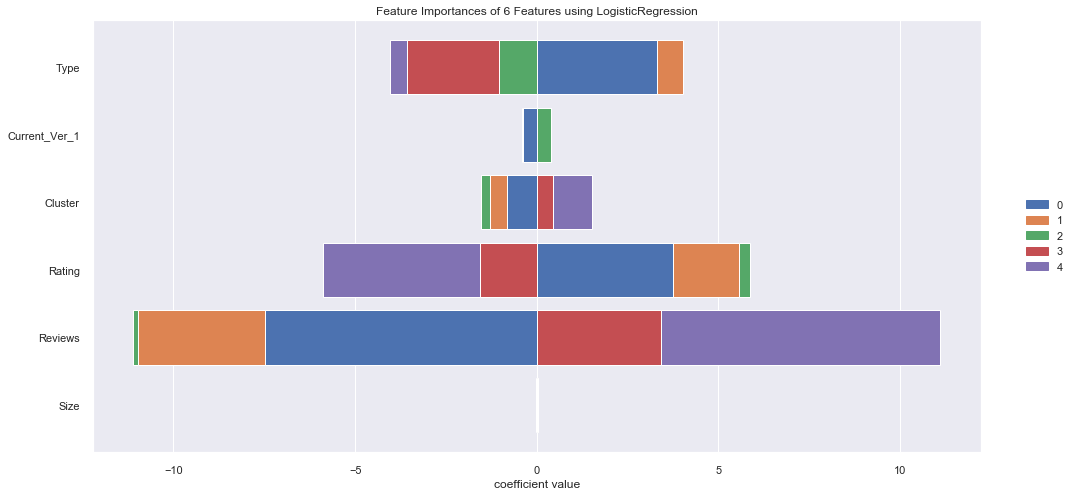

In [119]:
plt.figure(figsize=(15,7))

model = LogisticRegression(solver= 'newton-cg', multi_class='multinomial')
viz = FeatureImportances(model, stack=True, relative=False)
viz.fit(X_test2, y_pred2)
viz.show();

#### CV, Hyper-Parameter Tuning, and Balancing Dataset

In [ ]:
k_values=range(1,20)
for k in k_values:
    # define pipeline / Youn run of Xtrain instead of the whole dataset
    model=MultiOutputClassifier(RandomForestClassifier())
    over=SMOTE(sampling_strategy=(), k_neighbors=k)
    under=RandomUnderSampler(sampling_strategy=())
    steps=[('o',over),('u',under),('model',model)]
    pipeline=Pipeline(steps=steps)
    
    #evaluate Pipeline
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores=cross_val_score(pipeline, X_1_1,y1, scoring='precision',cv=cv, n_jobs=1)
    score=np.mean(scores)
    
    print(f'> k={k}, mean recall is {score}')

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_1_1,y1,stratify=y1, random_state=42)
# redefine the best model 
model=RandomForestClassifier()
over=SMOTE(sampling_strategy=0.1, k_neighbors=6)
under=RandomUnderSampler(sampling_strategy=0.5)
steps=[('o',over),('u',under)]
pipeline=Pipeline(steps=steps)

X_train,y_train = pipeline.fit_resample(X_train,y_train)

#hyperparameter tuning for Random Forest
params={'n_estimators':[10,100,1000],
'criterion':['gini','entropy'],
'max_depth':[None,5],
'bootstrap':[True, False],
'warm_start':[False,True],
'class_weight':[None,'balanced','balanced_subsample']}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search=GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, scoring='recall',cv=cv)
grid_result=grid_search.fit(X_train,y_train)

print(f'Best {grid_result.best_score_} using {grid_result.best_params_}')

In [ ]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y1)